# Simulación Lobos y Ovejas

In [1]:
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Constantes asumidas
NUM_SIMULACIONES = 6
INTERVALOS_TIEMPO = 300

#ENERGIA_INICIAL_LOBOS = 40
#ENERGIA_INICIAL_OVEJAS = 8
ENERGIA_COMIDA_LOBOS = 20
ENERGIA_COMIDA_OVEJAS = 4
ENERGIA_PERDIDA_STEP = 1
ENERGIA_PERDIDA_REPRODUCCION = 2 # a la mitad


PROB_REPRODUCCION_LOBO = 0.05 # 5%
PROB_REPRODUCCION_OVEJA = 0.04 # 4%
CONTADOR_CRECIMIENTO_INICIAL = 30
STATUS_PASTO_INICIAL = True

NUM_LOBOS_INICIAL = 50
NUM_OVEJAS_INICIAL = 100
WIDTH_GRID = 50
HEIGHT_GRID = 50

In [3]:
class Lobo(Agent):
    # Agentes que se comen a las ovejas.
    def __init__(self, unique_id, pos, e, model):
        # la clase agente guarda los ids y los enlaza con el modelo 
        # unique_id sirve para identificar a un agente
        # pos es una tupla en la grilla
        # e es la energía
        # model es pa usar cosas de la simulación aca adentro
        super().__init__(unique_id,model)
        # lobos tienen energia, y una posicion 
        self.energia = e
        self.pos = pos
    
    def move(self):
        # get_neighbourhood es utilidad de mesa pa devolver los vecinos
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=False,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
        self.energia -= ENERGIA_PERDIDA_STEP
        
    def step(self):
        self.move()
         
        # comerse alguna oveja que este en su grilla 
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        sheep = [obj for obj in cellmates if isinstance(obj, Oveja)]
        if len(sheep) > 0: 
            victima = self.random.choice(sheep)
            self.model.grid._remove_agent(self.pos, victima)
            self.model.schedule.remove(victima)
            self.energia += ENERGIA_COMIDA_LOBOS
            
        #si no tengo energia, muero 
        if self.energia < 0: 
            self.model.grid._remove_agent(self.pos, self)
            self.model.schedule.remove(self)
            return
        
        # tener hijos           
        if self.model.random.random() < PROB_REPRODUCCION_LOBO: 
            self.energia /= ENERGIA_PERDIDA_REPRODUCCION
            hijo = Lobo(self.model.next_id(),self.pos,self.energia,self.model)
            self.model.grid.place_agent(hijo, hijo.pos)
            self.model.schedule.add(hijo)

In [4]:
class Oveja(Agent):
    def __init__(self, unique_id, pos, energia, model):
        super().__init__(unique_id, model)
        self.pos = pos
        self.energia = energia

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=False,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
        self.energia -= ENERGIA_PERDIDA_STEP
        
    def step(self):
        self.move()
        
        # Comer Pasto
        celda_actual = self.model.grid.get_cell_list_contents([self.pos])
        pasto = [obj for obj in celda_actual if isinstance(obj, Pasto)][0]
        if pasto.crecido:
            self.energia += ENERGIA_COMIDA_OVEJAS
            pasto.crecido = False
        
        #si no tengo energia, muero 
        if self.energia < 0: 
            self.model.grid._remove_agent(self.pos, self)
            self.model.schedule.remove(self)
            return
        
        # Reproducción
        if self.model.random.random() < PROB_REPRODUCCION_OVEJA: 
            self.energia /= ENERGIA_PERDIDA_REPRODUCCION
            hija = Oveja(self.model.next_id(), self.pos, self.energia, self.model)
            self.model.grid.place_agent(hija, hija.pos)
            self.model.schedule.add(hija)

In [5]:
class Pasto(Agent):
    def __init__(self, unique_id, pos, model, crecido, contador_crecimiento):
        super().__init__(unique_id, model)
        self.pos = pos
        self.crecido = crecido
        self.contador_crecimiento = contador_crecimiento
        
    def step(self):
        if not self.crecido:
            # Si ya pasó tiempo de crecimiento, reiniciamos estado inicial pasto
            if self.contador_crecimiento <= 0:
                self.crecido = True
                self.contador_crecimiento = CONTADOR_CRECIMIENTO_INICIAL
            # Si no, disminuimos el contador
            else:
                self.contador_crecimiento -= 1                       

In [6]:
class LobosOvejasPastoModelo(Model):
    def __init__(self, num_lobos, num_ovejas, width, height):
        self.num_lobos = num_lobos
        self.num_ovejas = num_ovejas
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.current_id = 0
        
        # Crear lobos
        for i in range(self.num_lobos):
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            lobo = Lobo(self.next_id(), (x,y), self.random.randrange(2*ENERGIA_COMIDA_LOBOS), self)
            self.schedule.add(lobo)
            # Meto los lobos en un lugar al azar de la grilla
            self.grid.place_agent(lobo, (x, y))
            
        # Crer ovejas
        for i in range(self.num_ovejas):
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            oveja = Oveja(self.next_id(), (x,y) , self.random.randrange(2*ENERGIA_COMIDA_OVEJAS), self)
            self.schedule.add(oveja)
            # Agrego a un punto al azar de la grilla
            self.grid.place_agent(oveja, (x, y)) 
        
        # Crear pasto
        for agent, x, y in self.grid.coord_iter():
            crecido = self.random.choice([True, False])
            
            contador = CONTADOR_CRECIMIENTO_INICIAL
            if not crecido:
                contador= self.random.randrange(CONTADOR_CRECIMIENTO_INICIAL) 

            pasto = Pasto(self.next_id(), (x,y), self, crecido, contador)
            self.schedule.add(pasto)
            self.grid.place_agent(pasto, (x,y))

    def step(self):
        self.schedule.step()

Definido lo anterior, corremos la simulación, guardando la información para realizar los gráficos.

In [7]:
def simular(num_simulaciones, intervalos_tiempo):    
    
    ovejas = [] # [[], [] ... num_siluaciones]. Cada una de largo intervalos_tiempo con la cantidad de agentes de ese tipo
    lobos = []
    pasto = []

    for j in range(num_simulaciones):
        print("---> Simulación", j)
        ovejas.append([])
        lobos.append([])
        pasto.append([])
        model = LobosOvejasPastoModelo(NUM_LOBOS_INICIAL,NUM_OVEJAS_INICIAL, WIDTH_GRID, HEIGHT_GRID)

        for i in range(intervalos_tiempo):
            if i%100==0:
                print(i)
            model.step()
            ovejas[j].append(0)
            lobos[j].append(0)
            pasto[j].append(0)
            # matriz que cuenta cuantas oveja hay en una posición en un tiempo
            for agent in model.schedule.agents:
                if isinstance(agent, Oveja): 
                    ovejas[j][i] += 1
                if isinstance(agent, Lobo):
                    lobos[j][i] += 1
                if isinstance(agent, Pasto):
                    if agent.crecido:
                        pasto[j][i] += 1
            pasto[j][i] /= 4
                        
                    
    return ovejas, lobos, pasto
    
ovejas, lobos, pasto = simular(NUM_SIMULACIONES, INTERVALOS_TIEMPO)

---> Simulación 0
0
100
200
---> Simulación 1
0
100
200
---> Simulación 2
0
100
200
---> Simulación 3
0
100
200
---> Simulación 4
0
100
200
---> Simulación 5
0
100
200


Graficamos

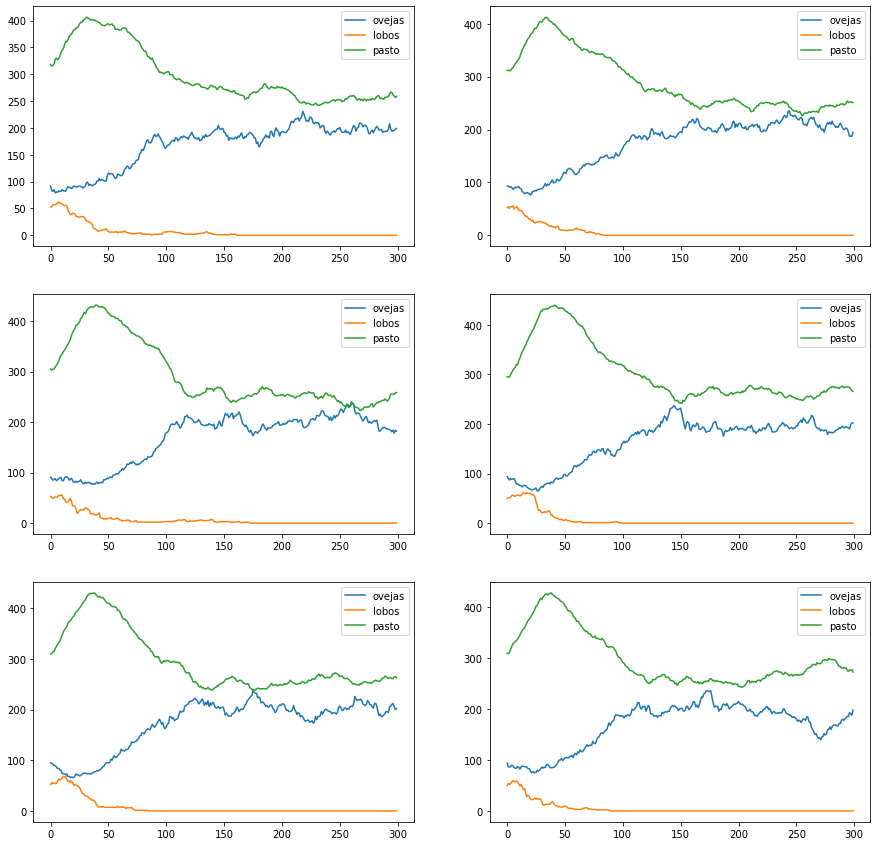

In [8]:
f, axs = plt.subplots(3,2,figsize=(15,15))

for i in range(NUM_SIMULACIONES):
    plt.subplot(3, 2, i+1) # subplot(nrows, ncols, index)
    plt.plot(ovejas[i], label = "ovejas")
    plt.plot(lobos[i], label = "lobos")
    plt.plot(pasto[i], label = "pasto")
    plt.legend()
    